# Aprendizaje de Máquina - Proyecto 1: Entrega 2

Universidad Andrés Bello

Abril 2024

Santiago, Chile

*Código Modelo 1 - RNN*

Integrantes:

• Felipe Gutiérrez

• Santiago Salvador

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, Dense, InputLayer
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\ra1n\AppData\Local\Temp\ipykernel_33432\1689287304.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Parte 1 - Preparación de datos

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CNANCUAN_201703-202204.csv")
df = pd.read_csv("CNANCUAN_201703-202204.csv")
df['fecha'] = pd.to_datetime(df['fecha'], utc=True)

# Probar con la subestacion AJAHUEL
subestaciones=["AJAHUEL","BUIN","CHENA","CNAVIA","ELSALTO","FLORIDA","LOSALME"]
selected=subestaciones[5]
df = df.loc[df['subestacion'] == selected]
#df = df[df['consumo'] != 0]
df = df.drop('subestacion', axis=1)

df = df.set_index('fecha')

# Crear secuencias de datos
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Definir conjuntos de datos de prueba y entrenamiento
train_mask = (df.index >= '2017-03-01') & (df.index <= '2021-03-31') # Filtrar datos de entrenamiento (2017-03 a 2021-03)
test_mask = (df.index >= '2021-04-01') & (df.index <= '2022-04-30') # Filtrar datos de prueba (2021-04 a 2022-04)

# Crear secuencias de tiempo
window_size = 7  # usaremos una ventana de 7 días
X_train, y_train = create_sequences(df[train_mask].values, window_size)
X_test, y_test = create_sequences(df[test_mask].values, window_size)

X_train, y_train = X_train[window_size:], y_train[window_size:]
X_test, y_test = X_test[window_size:], y_test[window_size:]

print(f"\nTotal datos de entrenamiento: {X_train.shape[0], y_train.shape[0]}")
print(f"\nTotal datos de prueba: {X_test.shape[0], y_test.shape[0]}")


Total datos de entrenamiento: (38712, 38712)

Total datos de prueba: (10595, 10595)


# Parte 2 - Entrenar el modelo de aprendizaje

In [3]:
# Definir la semilla para la reproducibilidad
seed=123456
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Crear un nuevo modelo RNN
model = Sequential()
model.add(InputLayer(batch_input_shape=(None, window_size, 1), name="serie"))
model.add(SimpleRNN(256))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))
model.summary()

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-3),
            loss='mse',
            metrics=['mse','mae'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# Entrenar el modelo utilizando el generador de imágenes
rnn = model.fit(X_train, y_train, batch_size=256, epochs=200, shuffle=True, verbose=1, callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))
model.save("generated/"+selected+".keras")

Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 82.5436 - mae: 4.1055 - mse: 82.5436
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 47.7768 - mae: 2.7482 - mse: 47.7768
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 44.7090 - mae: 2.6979 - mse: 44.7090
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 42.6402 - mae: 2.5282 - mse: 42.6402
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 41.4527 - mae: 2.4695 - mse: 41.4527
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 40.6563 - mae: 2.4384 - mse: 40.6563
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 40.1248 - mae: 2.4349 - mse: 40.1248
Epoch 8/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 39.5590 - mae: 2.4212 - mse: 39.5590
Epoch 9/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 38.8401 - mae: 2.3927 - mse: 38.8401
Epoch 10/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 38.2550 - mae: 2.3786 - mse: 38.2550
Epoch 11/200
152/15

# Parte 3 - Evaluar el modelo de aprendizaje

332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 17.60071467422195
MSE: 868.598343560301
MAPE: 346.94%


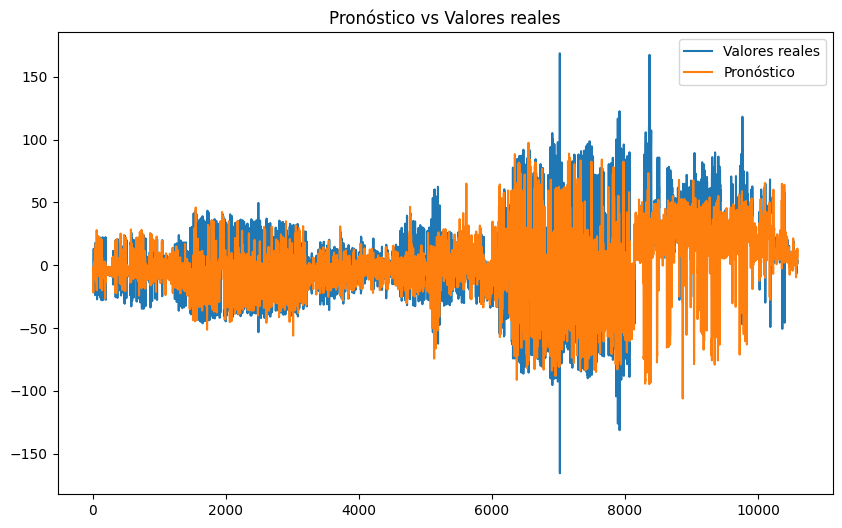

In [5]:
# Cargar el modelo
model = load_model("generated/"+selected+".keras")

# Graficar predicciones vs datos reales
yw=X_test
xw=[i for i in range(len(yw))]
pred=model.predict(yw)
xp = X_test[:, 0, 0]  # Selecciona la primera dimensión de X_test
yp = pred[:, 0]  # Selecciona la primera dimensión de pred

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xw, xp, label='Valores reales')
ax.plot(xw, yp, label='Pronóstico')
ax.set_title('Pronóstico vs Valores reales')
ax.legend()

# Calcular métricas
mean = abs(xp.mean())
MAE = mean_absolute_error(xp, yp)
MSE = mean_squared_error(xp, yp)
MAPE = (MAE/mean*100)
print(f"MAE: {MAE}")
print(f"MSE: {MSE}")
print(f"MAPE: {round(MAPE, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

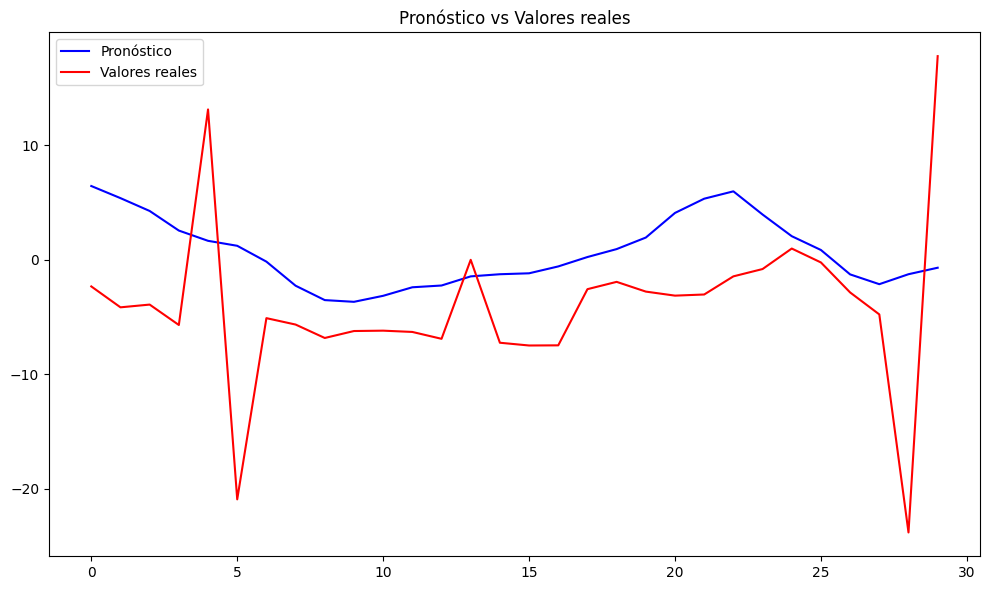

In [6]:
num_steps = 30 # Iteraciones a realizar para el forecast
ultimos_pasos = X_test[-1] # Toma los últimos 7 pasos de tiempo
forecasts = []

# Realiza el pronóstico para los siguientes pasos de tiempo
for _ in range(num_steps):
    forecast = model.predict(np.expand_dims(ultimos_pasos, axis=0))
    forecasts.append(forecast[0][0]) # Añade el valor pronosticado a la lista de pronósticos
    ultimos_pasos = np.concatenate([ultimos_pasos[1:], forecast], axis=0) # Añade el valor pronosticado a los últimos 7 pasos de tiempo

# Gráficar los valores pronosticados vs los valores reales
valores_reales = y_test[:num_steps] # Obtener los valores reales correspondientes al período de pronóstico

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(forecasts, label='Pronóstico', color='blue')
ax.plot(valores_reales, label='Valores reales', color='red')
ax.set_title('Pronóstico vs Valores reales')
ax.legend()

plt.tight_layout()
plt.show()